In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_normal = pd.read_hdf("data/dftrain.h5", header=None, sep=' ')
df_abnormal = pd.read_hdf("data/dfvalid.h5", header=None, sep=' ')


In [20]:
type(df_normal)

pandas.core.frame.DataFrame

In [4]:
df_normal.head()

,0,1,2,3,4,5,6,7,8,9,...,61430,61431,61432,61433,61434,61435,61436,61437,61438,61439
0,0.041259,0.041259,0.032573,0.023887,0.029315,0.041259,0.045602,0.038001,0.030401,0.032573,...,0.034744,-0.007600,-0.003257,0.065145,0.047773,-0.009772,0.031487,0.096632,0.077089,0.040173
1,-0.211722,-0.264924,-0.274696,-0.236694,-0.156349,-0.059716,0.005429,0.046687,0.153091,0.281210,...,0.260581,-0.004343,-0.241037,-0.636252,-0.953292,-0.980436,-0.846888,-0.838202,-0.880546,-0.739398
2,0.214105,0.154930,0.136640,0.013987,-0.038733,-0.015063,-0.111894,-0.104363,0.047340,-0.054871,...,0.040884,0.375490,0.699337,0.965085,1.086662,1.132926,1.279249,1.296464,0.937112,0.451879
3,-0.154837,-0.127768,-0.217638,-0.284770,-0.299929,-0.270694,-0.077960,0.092036,0.076877,0.154837,...,-0.286936,-0.171079,-0.036814,-0.024904,0.031400,0.140761,-0.011911,-0.173244,-0.063884,0.081208
4,-1.022780,-0.916376,-0.676425,-0.461445,-0.330069,-0.122690,0.178064,0.489675,0.799115,0.931577,...,1.009751,1.134613,0.836030,0.479903,0.109661,-0.285553,-0.628651,-0.916376,-1.010837,-0.804544


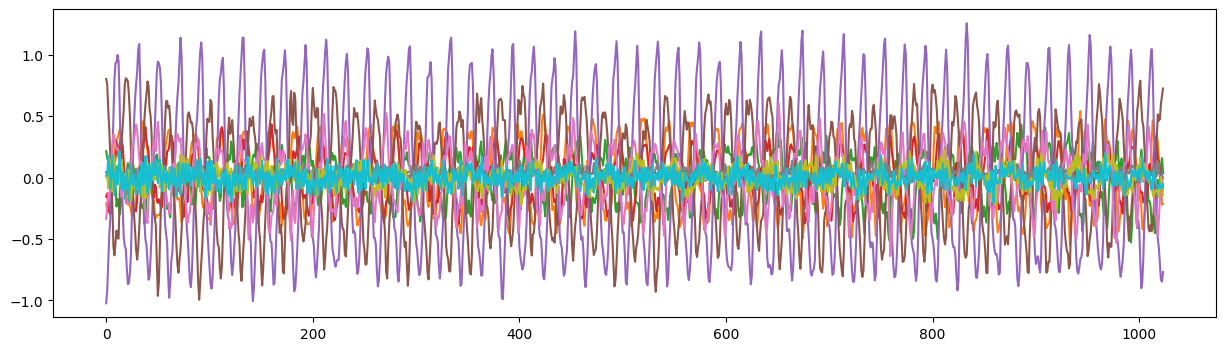

In [5]:
plt.figure(figsize=(15, 4))
for i in range(0, 10):
    plt.plot(df_normal.iloc[i][:1024])

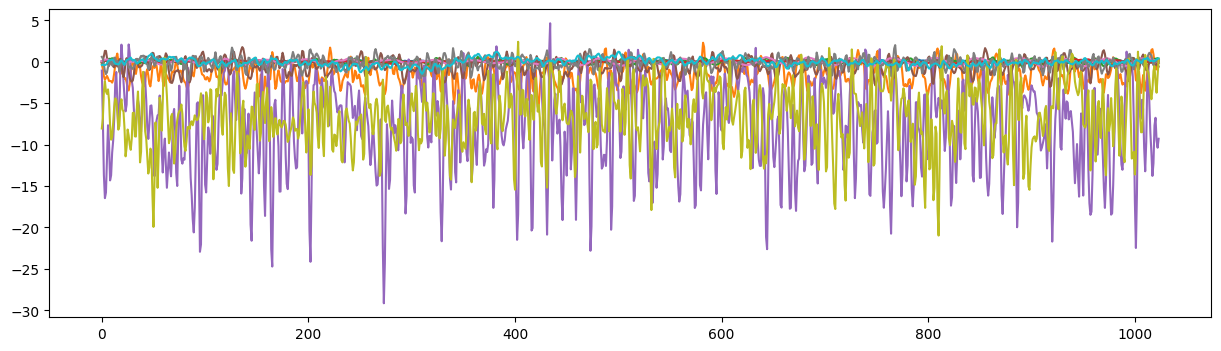

In [6]:
plt.figure(figsize=(15, 4))
for i in range(0, 10):
    plt.plot(df_abnormal.iloc[i][:1024])

In [3]:
df_normal['y']=1
df_abnormal['y']=0
combined_df = pd.concat([df_normal, df_abnormal], ignore_index=True)
shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)
raw_data = shuffled_df.values

In [25]:
type(raw_data)

numpy.ndarray

In [4]:
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [5]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [6]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [14]:
normal_train_data.shape

TensorShape([1342, 61440])

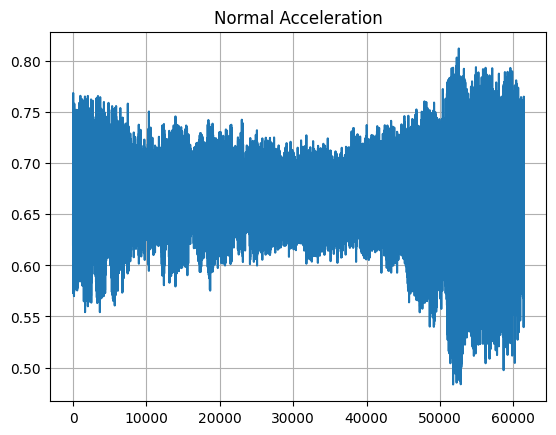

In [15]:
plt.grid()
plt.plot(np.arange(61440), normal_train_data[0])
plt.title("Normal Acceleration")
plt.show()

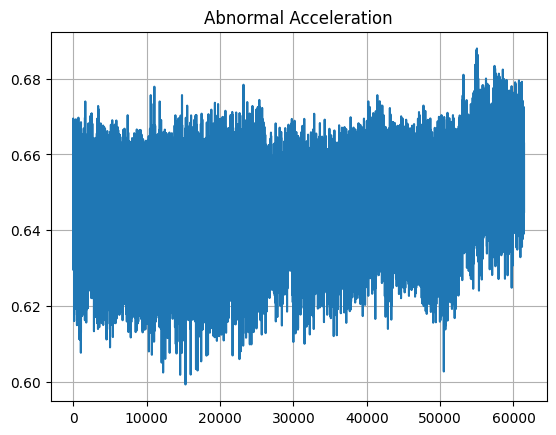

In [16]:
plt.grid()
plt.plot(np.arange(61440), anomalous_train_data[5])
plt.title("Abnormal Acceleration")
plt.show()

In [7]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    
    self.encoder = tf.keras.Sequential([ 
      layers.Dense(1024, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(1024, activation="relu"),
      layers.Dense(61440, activation="sigmoid")])
    

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded



In [12]:
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mae')

In [13]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=10,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - loss: 0.1569 - val_loss: 0.1212
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.1231 - val_loss: 0.0758
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0711 - val_loss: 0.0657
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0435 - val_loss: 0.0386
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0280 - val_loss: 0.0317
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0202 - val_loss: 0.0289
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0181 - val_loss: 0.0270
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0158 - val_loss: 0.0249
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 0.0141 - val_loss: 0.0227
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - loss: 0.0122 - val_loss: 0.0249


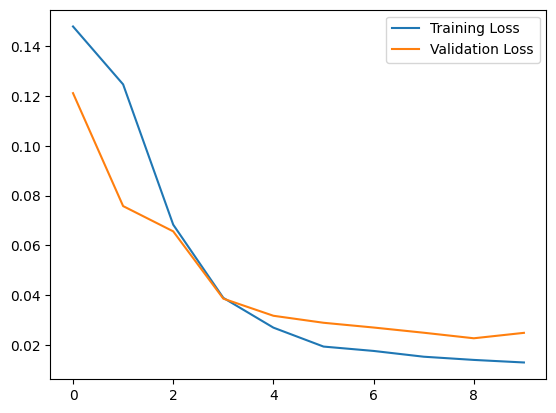

In [14]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

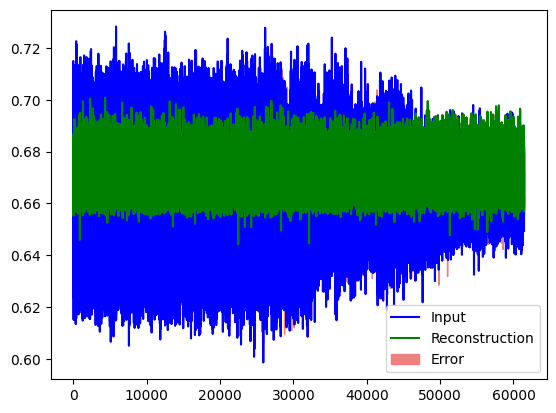

In [16]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'g')
plt.fill_between(np.arange(61440), decoded_data[5], normal_test_data[5], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

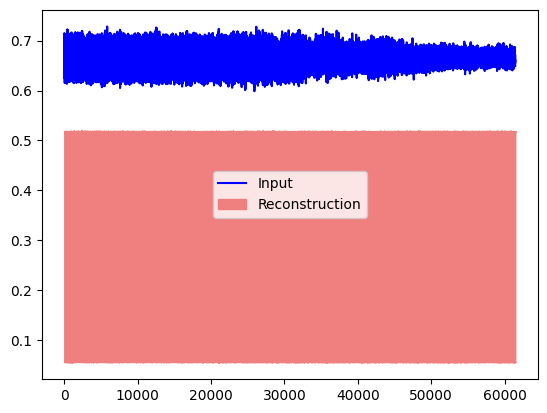

In [20]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
#plt.plot(decoded_data[0], 'g')
plt.fill_between(np.arange(61440), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step


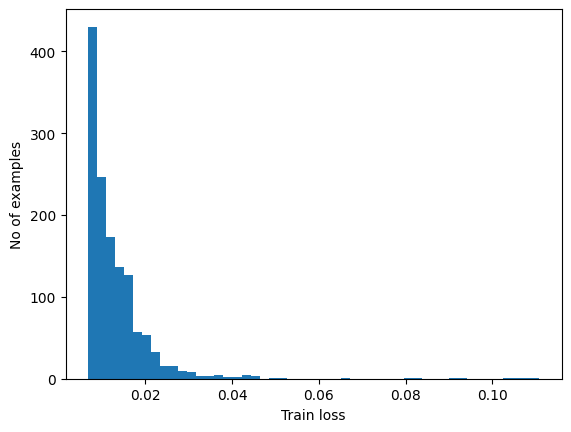

In [21]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [22]:
threshold = 2*(np.mean(train_loss) + np.std(train_loss))
print("Threshold: ", threshold)

Threshold:  0.045079283


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


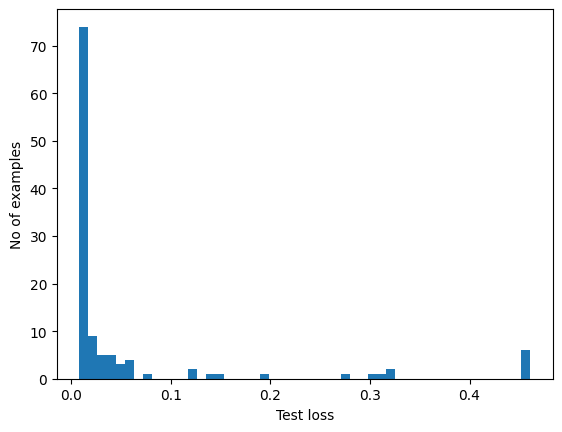

In [23]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
#plt.xlim(0.01, 0.05)
plt.ylabel("No of examples")
plt.show()

In [24]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [25]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.7912087912087912
Precision = 0.7819025522041764
Recall = 0.9970414201183432
